# Project 3a - Planetary Motion

## Due 2/14

Particle motion under gravity and drag are useful test cases because they are quite simple.  However, there are only so many things that can occur because there is no interaction between different particles.  An interesting generalization of particle motion is the case in which we do not assume uniform gravity, but rather use the full specification for the gravitational force between two particles $i$ and $j$, which is given by
$$ F_{ij} = -G\frac{m_i m_j}{|\mathbf{r}_{ij}|^3} \mathbf{r}_{ij}. $$
Note that this force is anti-symmetric, and leads to and acceleration in particle $i$ due to its interaction with particle $j$ that look like this
$$
\frac{\partial \mathbf{v}_i}{\partial t} = -G \frac{m_j}{|\mathbf{r}_{ij}|^3} \mathbf{r}_{ij}.
$$
$$
\frac{\partial \mathbf{v}_j}{\partial t} = -G \frac{m_i}{|\mathbf{r}_{ij}|^3} \mathbf{r}_{ji}.
$$
As before, when integrating Newton's laws of motion, the derivative of position is just velocity
$$
\frac{\partial \mathbf{x}_i}{\partial t} = \mathbf{v}_i.
$$

If we have $n$ particles, the forces are additive and we have that for a general particle $i$
$$
\frac{\partial \mathbf{x}_i}{\partial t} = \mathbf{v}_i.
$$
$$
\frac{\partial \mathbf{v}_i}{\partial t} = \sum_{k=1,k\neq i}^N -G \frac{m_k}{|\mathbf{r}_{ik}|^3} \mathbf{r}_{ik}.
$$

### Planetary motion problem
**Your first task is to create a planetary motion problem class using the same specification as before**.  Note that you will have to keep track of a few things: for each particle, you will have two coordinates and two velocities, for a total of $4N$ degrees of freedom.  You should be careful to choose an organizational structure that lets you keep these things straight. 

In [23]:
import numpy as np

class PlanetaryMotion:
    """ This is an example class for an ODE specification"""
    
    def __init__(self,G=6.67e-11,m=np.array([1.,1.]),n_bodies=2):
        self.n_bodies = n_bodies
        self.n_dof = n_bodies * 4 # each particle keeps track of 4 variables
        self.g = 1
        self.m = m
        

    def rhs(self,t,u):
        # the right hand side of the ode (or $\mathcal{F}(t,u)$)
        # implement u in a way that can take n bodies
        # u = |x1 x2 x3, y1 y2 y3, vx1 vx2 vx3, vy1 vy2 vy3|
        r = np.array([u[1] - u[0], u[3] - u[2]])
        r*=-1
        F = (-self.g*self.m[0]*self.m[1])/(np.linalg.norm(r)**3)*r
        dudt = np.zeros(self.n_dof)
        dudt[0] = u[4]
        dudt[1] = u[5]
        dudt[2] = u[6]
        dudt[3] = u[7]
        dudt[4] = F[0]/self.m[0]
        dudt[5] = -F[0]/self.m[1]
        dudt[6] = F[1]/self.m[0]
        dudt[7] = -F[1]/self.m[0]
        return dudt

    

### A conservative time stepping scheme
Unfortunately these equations are a bit picky: they are sensitive to accumulating errors in the system.  One way to account for this is to use a time-stepping scheme that conserves energy exactly: even if the integration isn't accurate, it will not blow up.  One such algorithm is the Euler-Cromer algorithm, which is given by Eq. 3.34 in Gould.  **Implement this time-stepping scheme**.

In [24]:
class EulerCromer:
    def __init__(self):
        pass   
    
    def step(self,ode,t,dt,u_0):
        split = ode.n_bodies * 2
        rhs_old = ode.rhs(t,u_0)
        rhs_new = ode.rhs(t+dt, u_0)
        
        vel_new = u_0[split:] + dt*rhs_new[split:]
        pos_new = u_0[:split] + dt*vel_new
        u_1 = np.concatenate((pos_new, vel_new))
        return u_1

### Integrating the equations of motion
We can use the same Integrator object as before.  **Integrate the equations of motion for a 2 body system.**  Setting the initial conditions can be a little bit tricky: not all conditions lead to stable orbits.  One such circumstance that does is for $m_1=1e4$,$m_2=1$, and $G=1$, with the velocity and position of particle 1 uniformly zero, and the velocity and position of particle 2 given by
$$
\mathbf{x}_2 = [100,0]
$$
$$
\mathbf{v}_2 = [0,10]
$$
**Plot the trajectory of the particle in whatever way seems suitable to you.** I find that plots of both position versus time, as well as x-position versus y-position are instructive.

In [25]:
class Integrator:
    def __init__(self,ode,method):
        self.ode = ode
        self.method = method
        
    def integrate(self,interval,dt,u_0):
        t_0 = interval[0]
        t_end = interval[1]
        
        times = [t_0]
        states = [u_0]
        
        t = t_0
        while t<t_end:
            dt_ = min(dt,t_end-t)
            u_1 = self.method.step(self.ode,t,dt_,u_0)
            t = t + dt_
            u_0 = u_1
            
            times.append(t)
            states.append(u_1)
            
        return np.array(times),np.array(states)

### Energy Conservation
If you implemented the above correctly, your particle should be moving in a stable, repeating, circular trajectory.  Now try again with Euler's method rather than Euler-Cromer.  What is happening here?  It turns out that Euler's method does not conserve energy.  We can illustrate this directly by computing the total energy of the system as a function of time.  There are two reservoirs of energy in this system: the gravitational potential energy, which is given by
$$
T = -\sum_{i=1}^N \sum_{k=1,i\neq k}^N G \frac{m_i m_k}{|\mathbf{r}_{ik}|}
$$
and the kinetic energy
$$
K = \sum_{i=1}^N \frac{1}{2} m_i v_i^2
$$
**Compute and plot $T + K$ at every time step for both the Euler-Cromer and Euler's method, and comment whether each method conserves energy**.


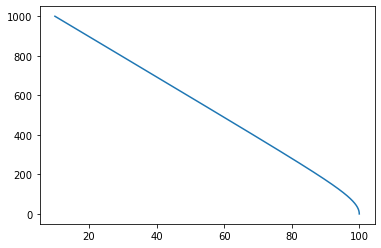

In [26]:
import matplotlib.pyplot as plt

pm = PlanetaryMotion()
method = EulerCromer()
integrator = Integrator(pm,method)

t_0 = 0.0
t_end = 100
dt = 0.01
particles_u = np.array([0,100,0,0,0,0,0,10])
t,u = integrator.integrate([t_0,t_end],dt,np.array(particles_u))

plt.plot(u[:,1],u[:,3])

### 3-body problem
**Add a third particle to the system**.  It may require a little bit of trial and error to find a stable trajectory (HINT: One stable configuration would add a particle 3 that is somehow symmetric with particle 2.  Explore modifications to the mass and initial conditions to see what kinds of things can happen to our little planets.  